# Spectroscopic factors

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ November 1, 2022

This notebook serves as a testbed for calculating spectroscopic factors using mean field approximations for initial and final states and applying SRG transformations to the operator. The normalization of spectroscopic overlaps give relative spectroscopic factors.

_Last update:_ January 24, 2022

__To-do list:__
* Sanity check by integrating over $k$, $k'$, and $K$ instead.
* Move functions and classes into scripts once you've settled on how to compute things.

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.special import spherical_jn, sph_harm
import shutil
from sympy.physics.quantum.cg import CG
import time
import vegas

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_nlj_state, label_nucleus
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import convert_l_to_string, coupled_channel
from scripts.woodsaxon import ws

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'
vmc_directory = '../data/vmc/momentum_distributions/'

## Classes

_Move some of these into scripts at a later date._

In [5]:
class SingleParticleState:
    
    
    def __init__(self, n, l, j, m_j, tau):
        self.n = n
        self.l = l
        self.j = j
        self.m_j = m_j
        self.tau = tau
        if tau == 1/2:
            self.nucleon = 'proton'
        elif tau == 1/2:
            self.nucleon = 'neutron'
        
        
    def __eq__(self, sp_state):
        if (
            self.n == sp_state.n and self.l == sp_state.l
            and self.j == sp_state.j and self.m_j == sp_state.m_j
            and self.tau == sp_state.tau
        ):
            return True
        else:
            return False
        
        
    def __str__(self):
        l_str = convert_l_to_string(self.l)  # E.g., 's', 'p', 'd', ...
        numerator = 2*int(self.j) + 1
        denominator = 2

        return fr"${self.n}{l_str}_{{{numerator}/{denominator}}}$"

In [6]:
class SingleParticleBasis:
    """
    Single-particle basis class. Handles the wave functions associated with the
    Wood-Saxon potential from the subroutine in woodsaxon.f90. Generates wave
    functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    n_max : int
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
        
    """
    
    
    def __init__(self, nucleus_name, Z, N, n_max, l_max, rmax=40, ntab=2000):

        # Generate orbitals
        self.run_wood_saxon_code(nucleus_name, Z, N, n_max, l_max, rmax, ntab)
                
        # Order single-particle states with lowest energy first
        self.order_sp_states(Z, N)
        
        # Move output files to relevant directory
        wood_saxon_directory = f"../data/wood_saxon/{nucleus_name}/"
        shutil.move("ws_log", wood_saxon_directory + "ws_log")
        shutil.move("ws_pot", wood_saxon_directory + "ws_pot")
        shutil.move("ws_rho", wood_saxon_directory + "ws_rho")

        # Move orbital files and organize wave functions in dictionary with
        # the file name as the key
        self.sp_wfs = {}
        for sp_state in self.sp_states:
            # Wave functions are independent of m_j, so fix m_j=j
            if sp_state.m_j == sp_state.j:
                file_name = self.get_orbital_file_name(sp_state)
                shutil.move(file_name, wood_saxon_directory + file_name)
                data = np.loadtxt(wood_saxon_directory + file_name)
                # Use file name as the key
                self.sp_wfs[file_name] = data[:, 1]

            
    def run_wood_saxon_code(
            self, nucleus_name, Z, N, n_max, l_max, rmax, ntab):
        """Run Wood-Saxon code to generate data."""
        
        # Total number of nucleons
        A = Z + N
        
        # Type of orbitals: 1 - nucleons with no Coulomb
        #                   2 - distinguish protons and neutrons
        ntau = 2
        
        # Orbitals to consider (note, we track 2*j not j)
        norb, lorb, jorb = [], [], []
        for n in range(1, n_max+1):
            for l in range(0, l_max+1):
                norb.append(n)
                lorb.append(l)
                jorb.append(int(2*(l+1/2)))
                if int(2*(l-1/2)) > 0:  # Don't append negative j
                    norb.append(n)
                    lorb.append(l)
                    jorb.append(int(2*(l-1/2)))
        nrad = len(jorb)
        orbws = np.zeros(shape=(2,nrad,ntab), order='F')
    
        # Divide orbital by r? -> get R(r); false: get u(r)=r R(r)
        rdiv = False
        dens = True
    
        # Set parameters of the Wood-Saxon potential
        prm = np.zeros(shape=(2,9), order='F')
    
        # Starting with vws (p & n)
        if nucleus_name == 'He4':
            # prm[:,0] = 76.8412
            prm[:,0] = 90.0  # For bound 1p_{1/2} state
        elif nucleus_name == 'O16':
            prm[:,0] = 58.0611
        elif nucleus_name == 'Ca40':
            prm[:,0] = 54.3051
        elif nucleus_name == 'Ca48':
            prm[0,0] = 59.4522
            prm[1,0] = 46.9322
    
        # Not sure about these (better way to load these parameters?)
        prm[:,1] = 1.275
        prm[:,2] = 0.7
        prm[:,3] = 0.
        prm[:,4] = 1.
        prm[:,5] = 36
        prm[:,6] = 1.32
        prm[:,7] = 0.7
        prm[:,8] = 1.275
        
        # Print summary, potentials, and densities
        prnt = True
        prntorb = True

        # Run Fortran subroutine
        ws(ntau, A, Z, rmax, orbws, norb, lorb, jorb, prm, rdiv, prnt, prntorb,
           dens)

        # Set radial distance array and step-size as instance attributes
        self.dr = rmax / ntab
        self.r_array = np.arange(self.dr, rmax + self.dr, self.dr)
        
        
    def order_sp_states(self, Z, N):
        """Keep track of all s.p. states and occupied s.p. states"""

        self.sp_states = []
        self.occ_states = []
        proton_count = 0
        neutron_count = 0
    
        # Order single-particle states using the ws_log file
        with open('ws_log', 'r') as f:
            for line in f:
                unit = line.strip().split()
                
                # Protons
                if len(unit) > 0 and unit[0] == '1':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, 1/2
                        )  # n, l, j, m_j, \tau
                    
                        self.sp_states.append(sp_state)
                    
                        if proton_count < Z:
                            self.occ_states.append(sp_state)
                            # Add up filled proton states
                            proton_count += 1
                    
                
                # Neutrons
                elif len(unit) > 0 and unit[0] == '2':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, -1/2
                        )  # n, l, j, m_j, \tau
                    
                        self.sp_states.append(sp_state)
                    
                        if neutron_count < N:
                            self.occ_states.append(sp_state)
                            # Add up filled neutron states
                            neutron_count += 1
                        
                        
    def get_orbital_file_name(self, sp_state):
        """Returns the file name of the orbital."""
        
        n, l, j = sp_state.n, sp_state.l, sp_state.j
        # Proton
        if sp_state.tau == 1/2:
            file_name = f"p.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
        # Neutron
        elif sp_state.tau == -1/2:
            file_name = f"n.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
        
        return file_name
                        
    
    def get_wf_rspace(self, sp_state, print_normalization=False):
        """Single-particle wave function in coordinate space."""
        
        # Orbital file name is the key
        u_array = self.sp_wfs[self.get_orbital_file_name(sp_state)]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr*u_array**2)
            print(f"Coordinate space normalization = {normalization}.")

        return self.r_array, u_array
    
    
    def fourier_transformation(self, l, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(self.r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        M = 1j**(-l) * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(
            l, k_rows*r_cols
        )
        
        return M
    
    
    def get_wf_kspace(
            self, sp_state, print_normalization=False, interpolate=False,
            kmax=15.0, kmid=3.0, ntot=120):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh with more points at low momentum
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        _, u_array = self.get_wf_rspace(sp_state)

        # Fourier-transform the wave function to momentum space
        phi_array = self.fourier_transformation(sp_state.l, k_array) @ u_array
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights*k_array**2*abs(phi_array)**2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            phi_func = interp1d(k_array, phi_array, kind='linear',
                                bounds_error=False, fill_value='extrapolate')
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array

In [7]:
class DeltaUDagger(SingleParticleBasis):
    """
    Matrix elements of \delta U^\dagger in the s.p. basis.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    n_max : int
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    channels : tuple
        Partial wave channels to include in the calculation.
    kvnn : int
        This number specifies the potential.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1] of the potential.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1] of the potential.
    ntot : int, optional
        Number of momentum points in mesh of the potential.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    
    """
    
    
    def __init__(
            self, nucleus_name, Z, N, n_max, l_max, channels, kvnn, rmax=40,
            ntab=2000, kmax=15.0, kmid=3.0, ntot=120, generator='Wegner',
            lamb=1.35):
        
        # Call SingleParticleBasis class given the specifications
        super().__init__(nucleus_name, Z, N, n_max, l_max, rmax, ntab)
        
        # Set instance attributes
        self.channels = channels
        self.kvnn = kvnn
        self.kmax = kmax
        self.kmid = kmid
        self.ntot = ntot
        self.generator = generator
        self.lamb = lamb
        
        # Precalculate Clebsch-Gordan table with j_max = 4
        self.cg_table = self.set_clebsch_gordan_table(4)
        
        # Spin projections
        self.spins = np.array([1/2, -1/2])

        # Set interpolating functions for s.p. wave functions \phi
        self.phi_functions = {}
        for sp_state in self.sp_states: 
            file_name = self.get_orbital_file_name(sp_state)
            self.phi_functions[file_name] = self.get_wf_kspace(sp_state,
                                                               interpolate=True)

        # Set interpolating functions for \delta U^\dagger
        self.delta_U_dagger_functions = {}
        for channel in channels:
            self.delta_U_dagger_functions[channel] = (
                self.interpolate_delta_U_dagger(channel)
            )
            
        # Directory for matrix element data
        # self.directory = f"../data/deltaU_matrix_elements/{nucleus_name}/"
    
    
    def set_clebsch_gordan_table(self, j_max):
        """
        Calculate Clebsch-Gordan coefficients for all combinations of j and m_j
        up to j_max.
    
        Parameters
        ----------
        j_max : int
            Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
        Returns
        -------
        cg_table : dict
            Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
            for each combination of angular momenta.
        
        """
        
        cg_table = {}
        
        j_array = np.arange(0, j_max+1/2, 1/2)

        for j_1 in j_array:
            for m_1 in np.arange(-j_1, j_1+1, 1):
                for j_2 in j_array:
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        for j_3 in j_array:
                            for m_3 in np.arange(-j_3, j_3+1, 1):
                                cg_table[(j_1,m_1,j_2,m_2,j_3,m_3)] = float(
                                    CG(j_1,m_1,j_2,m_2,j_3,m_3).doit()
                                )
                                
        return cg_table

    
    def get_channel_str(self, Lp, L, S, J):
        """Gets the partial wave channel string given quantum numbers."""
    
        # Total orbital angular momentum L' = 0, 1, 2, ...
        if Lp == 0:
            Lp_str = 'S'
        elif Lp == 1:
            Lp_str = 'P'
        elif Lp == 2:
            Lp_str = 'D'
        elif Lp == 3:
            Lp_str = 'F'
        elif Lp == 4:
            Lp_str = 'G'
        elif Lp == 5:
            Lp_str = 'H'
        else:
            raise RuntimeError("Channel L' exceeds the range of the function.")
        
        channel = f"{2*S+1}{Lp_str}{J}"
    
        # Total orbital angular momentum L = 0, 1, 2, ...
        # L = L' if the channel is not coupled
        if channel in ['3S1', '3D1', '3P2', '3F2', '3D3', '3G3']:
        
            if L == 0:
                L_str = 'S'
            elif L == 1:
                L_str = 'P'
            elif L == 2:
                L_str = 'D'
            elif L == 3:
                L_str = 'F'
            elif L == 4:
                L_str = 'G'
            elif L == 5:
                L_str = 'H'
            else:
                raise RuntimeError(
                    "Channel L exceeds the range of the function."
                )
            
            channel += f"-{2*S+1}{L_str}{J}"

        return channel
    
    
    def get_channel_quantum_numbers(self, channel):
        """Gets the quantum numbers of a partial wave channel."""
    
        # Total orbital angular momentum L' = 0, 1, 2, ...
        if channel[1] == 'S':
            Lp = 0
        elif channel[1] == 'P':
            Lp = 1
        elif channel[1] == 'D':
            Lp = 2
        elif channel[1] == 'F':
            Lp = 3
        elif channel[1] == 'G':
            Lp = 4
        elif channel[1] == 'H':
            Lp = 5
        else:
            raise RuntimeError("Channel L' exceeds the range of the function.")
    
        # Total orbital angular momentum L = 0, 1, 2, ...
        if coupled_channel(channel[:3]):
        
            if channel[5] == 'S':
                L = 0
            elif channel[5] == 'P':
                L = 1
            elif channel[5] == 'D':
                L = 2
            elif channel[5] == 'F':
                L = 3
            elif channel[5] == 'G':
                L = 4
            elif channel[5] == 'H':
                L = 5
            else:
                raise RuntimeError(
                    "Channel L exceeds the range of the function."
                )
        
        # L = L' if the channel is not coupled
        else:
        
            L = Lp
        
        # Total spin S = 0 or 1
        S = int((int(channel[0])-1)/2)
    
        # Total angular momentum J = 0, 1, 2, ...
        J = int(channel[2])
            
        return Lp, L, S, J
    
    
    def get_total_isospin(self, L, S):
        """Total isospin according to antisymmetry."""
    
        # Make sure [1-(-1)^(L+S+T)] is not zero
        if (1-(-1)**(L+S)) == 0:
            T = 1
        else:
            T = 0
        
        return T
    
    
    def interpolate_delta_U_dagger(self, channel):
        """Interpolate \delta U^\dagger(k',k) for the given channel."""
    
        # Set channel argument to be compatible with potential functions
        if channel[:3] in ['3S1', '3D1']:
            channel_arg = '3S1'
        elif channel[:3] in ['3P2', '3F2']:
            channel_arg = '3P2'
        elif channel[:3] in ['3D3', '3G3']:
            channel_arg = '3D3'
        else:
            channel_arg = channel[:3]
        
        # Set potential
        potential = Potential(self.kvnn, channel_arg, self.kmax, self.kmid,
                              self.ntot)
    
        # Get momentum mesh
        k_array, k_weights = potential.load_mesh()
    
        # Initial and evolved Hamiltonians
        H_initial = potential.load_hamiltonian()
        if self.generator == 'Block-diag':
            H_evolved = potential.load_hamiltonian('srg', self.generator, 1.0,
                                                   lambda_bd=self.lamb)
        else:
            H_evolved = potential.load_hamiltonian('srg', self.generator,
                                                   self.lamb)
    
        # Get SRG transformation from Hamiltonians
        U_matrix_weights = get_transformation(H_initial, H_evolved)
    
        # Calculate \delta U^\dagger = (U - I)^\dagger
        I_matrix_weights = np.eye(len(U_matrix_weights), len(U_matrix_weights))
        delUdag_matrix_weights = (U_matrix_weights - I_matrix_weights).T

        # Get specific sub-block if coupled-channel
        n = self.ntot
        if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[:n,n:2*n]
            )
        elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[n:2*n,:n]
            )
        elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[n:2*n,n:2*n]
            )
        else:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[:n,:n]
            )
        
        # Interpolate \delta U^\dagger(k,k')
        delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix)

        return delUdag_func
    

    # Fix this docstring
    def compute_matrix_element(self, alpha, beta, gamma, delta):
        """
        Compute the specified matrix element of \delta U^\dagger.
        
        Parameters
        ----------
        n_* : int
            Principal quantum number n = 1, 2, 3, ...
        l_* : int
            Orbital angular momentum l = 0, 1, 2, ...
        j_* : float
            Total angular momentum j = 1/2, 3/2, 5/2, ...
        m_j_* : float
            Total angular momentum projection m_j = -j, -j+1, ..., j.
        tau_* : float
            Isospin projection \tau = +1/2 or -1/2.
        
        Returns
        -------
        delta_U_dagger : float
            Matrix element of \delta U^\dagger in the s.p. basis.
        
        """
        
        # Get all possible combinations of quantum numbers that give non-zero
        # contributions to the matrix element of \delta U^\dagger
        combinations = self.get_nonzero_combinations(alpha, beta, gamma, delta)
        # Note, there will still be some combinations that give zero because of
        # orthogonality of s.p. and relative spherical harmonics (e.g., all
        # s-waves for s.p. with a D-wave for relative)

        # Non-empty list
        if combinations:
        
            # Set-up integration with vegas up to k_max = 10 fm^-1
            k_limits = [0, 10]
            theta_limits = [0, np.pi]
            phi_limits = [0, 2*np.pi]
            integ = vegas.Integrator([k_limits, theta_limits, phi_limits,
                                      k_limits, theta_limits, phi_limits,
                                      k_limits, theta_limits, phi_limits])

            self.combinations = combinations

            integrand_real = lambda x: self.integrand(x, alpha, beta, gamma,
                                                      delta).real
            integrand_imag = lambda x: self.integrand(x, alpha, beta, gamma,
                                                      delta).imag
        
            # Compute integrations over k1, k2, and k3 vectors
            result_real = integ(integrand_real, nitn=10, neval=1e4)
            result_imag = integ(integrand_imag, nitn=10, neval=1e4)
            
            ### TESTING
#             print(result_real.summary())
#             print(result_real)

            delta_U_dagger = result_real.mean + 1j*result_imag.mean

        # Combination of s.p. states is zero
        else:
        
            delta_U_dagger = 0.0
        
        return delta_U_dagger
    
    
    def get_nonzero_combinations(self, alpha, beta, gamma, delta):
        """Returns all combinations of quantum numbers that give a non-zero
        product of Clebsch-Gordan coefficients in the calculation of the
        \delta U^\dagger matrix element.
        """
    
        # Initialize list to store non-zero combinations of quantum numbers
        combinations = []
        
        # Set range of m_l values
        m_l_alphas = np.intersect1d(np.arange(-alpha.l, alpha.l+1, 1),
                                    alpha.m_j - self.spins)
        m_l_betas = np.intersect1d(np.arange(-beta.l, beta.l+1, 1),
                                    beta.m_j - self.spins)
        m_l_gammas = np.intersect1d(np.arange(-gamma.l, gamma.l+1, 1),
                                    gamma.m_j - self.spins)
        m_l_deltas = np.intersect1d(np.arange(-delta.l, delta.l+1, 1),
                                    delta.m_j - self.spins)
    
        # Loop over single-particle orbital angular momentum projections first
        for m_l_alpha in m_l_alphas:
            sigma_alpha = alpha.m_j - m_l_alpha

            for m_l_beta in m_l_betas:
                sigma_beta = beta.m_j - m_l_beta

                for m_l_gamma in m_l_gammas:
                    sigma_gamma = gamma.m_j - m_l_gamma
                                
                    for m_l_delta in m_l_deltas:
                        sigma_delta = delta.m_j - m_l_delta
        
                        # Loop over channels
                        for channel in self.channels:
                        
                            # Determine channel quantum numbers
                            Lp, L, S, J = self.get_channel_quantum_numbers(
                                channel
                            )
                        
                            # Possible M_L' values
                            M_Lp_array = np.arange(-Lp, Lp+1, 1)
                        
                            # Possible M_L values
                            M_L_array = np.arange(-L, L+1, 1)
                        
                            # Possible M_S values
                            M_S_array = np.arange(-S, S+1, 1)
                        
                            # Possible M_J values
                            M_J_array = np.arange(-J, J+1, 1)
                
                            # Determine total isospin
                            T = self.get_total_isospin(L, S)
                        
                            # Possible M_T values
                            M_T_array = np.arange(-T, T+1, 1)
                        
                            for M_Lp in M_Lp_array:
                            
                                for M_L in M_L_array:
                                
                                    for M_S in M_S_array:
                                    
                                        # Spin CG's
                                        alpha_beta_spin_cg = self.cg_table[(
                                            1/2, sigma_alpha, 1/2, sigma_beta,
                                            S, M_S
                                        )]
                                        gamma_delta_spin_cg = self.cg_table[(
                                            1/2, sigma_gamma, 1/2, sigma_delta,
                                            S, M_S
                                        )]
                                    
                                        for M_J in M_J_array:
                                        
                                            # L-S coupling CG's
                                            Lp_S_J_cg = self.cg_table[(
                                                Lp, M_Lp, S, M_S, J, M_J
                                            )]
                                            L_S_J_cg = self.cg_table[(
                                                L, M_L, S, M_S, J, M_J
                                            )]
                                        
                                            for M_T in M_T_array:
                                            
                                                # Isopin CG's
                                                alpha_beta_isospin_cg = (
                                                    self.cg_table[(
                                                        1/2, alpha.tau, 1/2,
                                                        beta.tau, T, M_T
                                                    )]
                                                )
                                                gamma_delta_isospin_cg = (
                                                    self.cg_table[(
                                                        1/2, gamma.tau, 1/2,
                                                        delta.tau, T, M_T
                                                    )]
                                                )
                                            
                                                # Calculate product of CG's
                                                product = (
                                                    alpha_beta_spin_cg
                                                    * gamma_delta_spin_cg
                                                    * Lp_S_J_cg * L_S_J_cg
                                                    * alpha_beta_isospin_cg
                                                    * gamma_delta_isospin_cg
                                                )
                                            
                                                # Append combination if the
                                                # product is non-zero
                                                if product != 0:
                                                
                                                    quantum_numbers = {
                                                        'm_l_alpha': m_l_alpha,
                                                        'm_l_beta': m_l_beta,
                                                        'm_l_gamma': m_l_gamma,
                                                        'm_l_delta': m_l_delta,
                                                        'sigma_alpha': sigma_alpha,
                                                        'sigma_beta': sigma_beta,
                                                        'sigma_gamma': sigma_gamma,
                                                        'sigma_delta': sigma_delta,
                                                        'Lp': Lp, 'M_Lp': M_Lp,
                                                        'L': L, 'M_L': M_L,
                                                        'S': S, 'M_S': M_S,
                                                        'J': J, 'M_J': M_J,
                                                        'T': T, 'M_T': M_T                    
                                                    }
                                                
                                                    combinations.append(
                                                        quantum_numbers
                                                    )

        return combinations
    
    
    def integrand(self, momenta_array, alpha, beta, gamma, delta):
        """Integrand of the specified \delta U^\dagger matrix element."""
    
#         # Get particular combination of quantum numbers m_l, \sigma, L', etc.
#         quantum_numbers = self.quantum_numbers

        # Single-particle momenta
        k1, theta1, phi1 = momenta_array[:3]
        k1_vector = np.array([k1 * np.sin(theta1) * np.cos(phi1),
                              k1 * np.sin(theta1) * np.sin(phi1),
                              k1 * np.cos(theta1)])
        
        k2, theta2, phi2 = momenta_array[3:6]
        k2_vector = np.array([k2 * np.sin(theta2) * np.cos(phi2),
                              k2 * np.sin(theta2) * np.sin(phi2),
                              k2 * np.cos(theta2)])
        
        k3, theta3, phi3 = momenta_array[6:]
        k3_vector = np.array([k3 * np.sin(theta3) * np.cos(phi3),
                              k3 * np.sin(theta3) * np.sin(phi3),
                              k3 * np.cos(theta3)])
    
        # Compute k_4 vector and each of its components
        k4_vector = k1_vector + k2_vector - k3_vector
        k4 = la.norm(k4_vector)
        theta4 = np.arccos(k4_vector[2]/k4)
        phi4 = np.arctan2(k4_vector[1], k4_vector[0])
        
        # Compute k' vector and each of its components
        kp_vector = (k1_vector-k2_vector)/2
        kp = la.norm(kp_vector)
        thetap = np.arccos(kp_vector[2]/kp)
        phip = np.arctan2(kp_vector[1], kp_vector[0])
        
        # Compute k vector and each of its components
        k_vector = (k3_vector-k4_vector)/2
        k = la.norm(k_vector)
        theta = np.arccos(k_vector[2]/k)
        phi = np.arctan2(k_vector[1], k_vector[0])
        
        # Calculate the Jacobian determinant
        jacobian = (k1**2 * np.sin(theta1) * k2**2 * np.sin(theta2) * k3**2 
                    * np.sin(theta3))
    
        # Evaluate single-particle wave functions \phi(k) at k1, k2, k3, and k4
        phi_alpha = np.conj(
            self.phi_functions[self.get_orbital_file_name(alpha)](k1)
        )
        phi_beta = np.conj(
            self.phi_functions[self.get_orbital_file_name(beta)](k2)
        )
        phi_gamma = self.phi_functions[self.get_orbital_file_name(gamma)](k3)
        phi_delta = self.phi_functions[self.get_orbital_file_name(delta)](k4)

        integrand = 0.0
        for quantum_numbers in self.combinations:
    
            # Get s.p. orbital angular momentum projections
            m_l_alpha = quantum_numbers['m_l_alpha']
            m_l_beta = quantum_numbers['m_l_beta']
            m_l_gamma = quantum_numbers['m_l_gamma']
            m_l_delta = quantum_numbers['m_l_delta']
    
            # Get s.p. spin projections
            sigma_alpha = quantum_numbers['sigma_alpha']
            sigma_beta = quantum_numbers['sigma_beta']
            sigma_gamma = quantum_numbers['sigma_gamma']
            sigma_delta = quantum_numbers['sigma_delta']
    
            # Get total orbital angular momentum and its projection
            Lp, M_Lp = quantum_numbers['Lp'], quantum_numbers['M_Lp']
            L, M_L = quantum_numbers['L'], quantum_numbers['M_L']
    
            # Get total spin and its projection
            S, M_S = quantum_numbers['S'], quantum_numbers['M_S']
    
            # Get total angular momentum and its projection
            J, M_J = quantum_numbers['J'], quantum_numbers['M_J']
    
            # Get total isospin and its projection
            T, M_T = quantum_numbers['T'], quantum_numbers['M_T']
    
            # Calculate s.p. l-s coupling Clebsch-Gordan coefficients
            alpha_cg = self.cg_table[(alpha.l, m_l_alpha, 1/2, sigma_alpha,
                                      alpha.j, alpha.m_j)]
            beta_cg = self.cg_table[(beta.l, m_l_beta, 1/2, sigma_beta, beta.j,
                                     beta.m_j)]
            gamma_cg = self.cg_table[(gamma.l, m_l_gamma, 1/2, sigma_gamma,
                                      gamma.j, gamma.m_j)]
            delta_cg = self.cg_table[(delta.l, m_l_delta, 1/2, sigma_delta,
                                      delta.j, delta.m_j)]
    
            # Calculate spin Clebsch-Gordan coefficients
            alpha_beta_spin_cg = self.cg_table[(1/2, sigma_alpha, 1/2,
                                                sigma_beta, S, M_S)]
            gamma_delta_spin_cg = self.cg_table[(1/2, sigma_gamma, 1/2,
                                                 sigma_delta, S, M_S)]
    
            # Calculate isospin Clebsch-Gordan coefficients
            alpha_beta_isospin_cg = self.cg_table[(1/2, alpha.tau, 1/2,
                                                   beta.tau, T, M_T)]
            gamma_delta_isospin_cg = self.cg_table[(1/2, gamma.tau, 1/2,
                                                    delta.tau, T, M_T)]
    
            # Calculate L-S coupling Clebsch-Gordan coefficients
            Lp_S_J_cg = self.cg_table[(Lp, M_Lp, S, M_S, J, M_J)]
            L_S_J_cg = self.cg_table[(L, M_L, S, M_S, J, M_J)]
    
            # Calculate spherical harmonics
            Y_alpha = np.conj(sph_harm(m_l_alpha, alpha.l, phi1, theta1))
            Y_beta = np.conj(sph_harm(m_l_beta, beta.l, phi2, theta2))
            Y_gamma = sph_harm(m_l_gamma, gamma.l, phi3, theta3)
            Y_delta = sph_harm(m_l_delta, delta.l, phi4, theta4)
            Y_Lp = np.conj(sph_harm(M_Lp, Lp, phip, thetap))
            Y_L = sph_harm(M_L, L, phi, theta)
    
            # Calculate 1-(-1)^(L'+S+T) and 1-(-1)^(L+S+T) factors
            factor = (1-(-1)**(Lp+S+T)) * (1-(-1)**(L+S+T))
        
            # Get the partial wave channel following spectroscopic notation
            channel = self.get_channel_str(Lp, L, S, J)
    
            # Calculate \delta U^\dagger(k', k)
            delta_U_dagger = self.delta_U_dagger_functions[channel].ev(kp, k)
            
            integrand += 1/2 * (
                alpha_cg * beta_cg * gamma_cg * delta_cg * alpha_beta_spin_cg
                * gamma_delta_spin_cg * alpha_beta_isospin_cg
                * gamma_delta_isospin_cg * Lp_S_J_cg * L_S_J_cg * phi_alpha 
                * phi_beta * phi_gamma * phi_delta * Y_alpha * Y_beta * Y_gamma
                * Y_delta * Y_Lp * Y_L * factor * delta_U_dagger * jacobian
            )
             
        return integrand

    
    def save_matrix_elements(self):
        
        data_list = []
        t0 = time.time()
        
        count, last_percent = 0, 0
        # Loop over s.p. states
        for alpha in self.sp_states:
            for beta in self.sp_states:
                for gamma in self.sp_states:
                    for delta in self.sp_states:
                        
                        if alpha.tau + beta.tau == gamma.tau + delta.tau:
                        
                            # Compute the matrix element
                            delta_U_dagger = self.compute_matrix_element(
                                alpha, beta, gamma, delta
                            )
                        
                            row = {
                                'n_alpha': alpha.n, 'l_alpha': alpha.l,
                                'j_alpha': alpha.j, 'm_j_alpha': alpha.m_j,
                                'tau_alpha': alpha.tau,
                                'n_beta': beta.n, 'l_beta': beta.l,
                                'j_beta': beta.j, 'm_j_beta': beta.m_j,
                                'tau_beta': beta.tau,
                                'n_gamma': gamma.n, 'l_gamma': gamma.l,
                                'j_gamma': gamma.j, 'gamma.m_j': gamma.m_j,
                                'tau_gamma': gamma.tau,
                                'n_delta': delta.n, 'l_delta': delta.l,
                                'j_delta': delta.j, 'm_j_delta': delta.m_j,
                                'tau_delta': delta.tau,
                                'delta_U_dagger': delta_U_dagger
                            }
                            data_list.append(row)
                            
                        # Track progress
                        count += 1
                        percent = count/(len(self.sp_states)**4)*100
                        if percent > (last_percent+5):
                            print(f"{percent:.2f}% done.")
                            last_percent = percent
                        
        t1 = time.time()
        mins = (t1-t0)/60
        print(f"Done generating all matrix elements after {mins} minutes.")
                        
        file_name = (f"delta_U_dagger_matrix_elements_{self.nucleus_name}_kvnn"
                     f"_{self.kvnn}.csv")
        
        # Convert to data frame and save
        df = pd.DataFrame(data_list)
        df.to_csv(self.directory + file_name)

In [8]:
class SpectroscopicAmplitude(DeltaUDagger):
    """
    Spectroscopic amplitude class. Calculates the overlap
    
        < \Psi_\alpha^{A-1} | a_\mathbf{q} | \Psi_0^A >
        
    using SRG transformations, where \alpha is some single-particle state
    specified by n, l, j, m_j, and \tau.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    n_max : int
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    channels : tuple
        Partial wave channels to include in the calculation.
    kvnn : int
        This number specifies the potential.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1] of the potential.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1] of the potential.
    ntot : int, optional
        Number of momentum points in mesh of the potential.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    
    """
    
    
    def __init__(
            self, nucleus_name, Z, N, n_max, l_max, channels, kvnn, rmax=40,
            ntab=2000, kmax=15.0, kmid=3.0, ntot=120, generator='Wegner',
            lamb=1.35):
        
        # Call DeltaUDagger super-class given the specifications
        super().__init__(nucleus_name, Z, N, n_max, l_max, channels, kvnn, rmax,
                         ntab, kmax, kmid, ntot, generator, lamb)
        
        # Initialize momenta q and its angles
        self.q_array, self.q_weights = gaussian_quadrature_mesh(10.0, 120)

        # \theta_q goes from 0 to \pi
        theta_q_array, theta_q_weights = gaussian_quadrature_mesh(np.pi, 7)
        
        # \phi_q goes from 0 to 2\pi
        phi_q_array, phi_q_weights = gaussian_quadrature_mesh(2*np.pi, 11)
        
        # Set-up meshgrids for q_vector and integration over angles
        self.q_grid, self.theta_grid, self.phi_grid = np.meshgrid(
            self.q_array, theta_q_array, phi_q_array, indexing='ij'
        )
        _, self.dtheta_grid, self.dphi_grid = np.meshgrid(
            self.q_array, np.sin(theta_q_array) * theta_q_weights,
            phi_q_weights, indexing='ij'
        )
        
        # Directory for spectroscopic amplitudes data
        self.directory = f"../data/spectroscopic_amplitudes/{nucleus_name}/"
        
        
    def compute_I_term(self, alpha):
        """Compute the I term in the spectroscopic amplitude."""
        
        # I term
        I_grid = np.zeros_like(self.q_grid, dtype='complex')
    
        # Calculate \phi_\alpha(q)
        phi_alpha_grid = self.phi_functions[self.get_orbital_file_name(alpha)](
            self.q_grid
        )
    
        # Set range of possible m_l_\alpha values
        m_l_alphas = np.intersect1d(np.arange(-alpha.l, alpha.l+1, 1),
                                    alpha.m_j - self.spins)
            
        for m_l_alpha in m_l_alphas:
        
            # Calculate Y_{l_\alpha m_l_\alpha}(q)
            Y_alpha_grid = sph_harm(m_l_alpha, alpha.l, self.phi_grid,
                                    self.theta_grid)
        
            # Calculate \sigma_\alpha
            sigma_alpha = alpha.m_j - m_l_alpha
        
            # Calculate \alpha CG
            alpha_cg = self.cg_table[(alpha.l, m_l_alpha, 1/2, sigma_alpha,
                                      alpha.j, alpha.m_j)]
        
            I_grid += phi_alpha_grid * Y_alpha_grid * alpha_cg
            
        return I_grid
        
    
    def compute_delta_U_dagger_term(self, alpha):
        """Compute the \delta U^\dagger term in the spectroscopic amplitude."""
        
        # All allowed single-particle states \beta
        # \tau_\beta must equal \tau_\alpha from the following:
        #     \tau_\beta + \tau_\gamma = M_T = \tau_\alpha + \tau_\gamma
        betas = []
        for beta in self.sp_states:
            if beta.tau == alpha.tau:
                betas.append(beta)

        # All occupied single-particle states \gamma
        gammas = self.occ_states
        
        # \delta U^\dagger term
        delta_U_dagger_grid = np.zeros_like(self.q_grid, dtype='complex')

        # Sum over \beta is unrestricted
        for beta in betas:

            # Calculate \phi_\alpha(q)
            phi_beta_grid = self.phi_functions[
                self.get_orbital_file_name(beta)
            ](self.q_grid)
            
            # Set range of possible m_l_\beta values
            m_l_betas = np.intersect1d(np.arange(-beta.l, beta.l+1, 1),
                                       beta.m_j - self.spins)
        
            # Sum over \gamma is restricted to states < F
            for gamma in gammas:
                
                delta_U_dagger = self.compute_matrix_element(beta, gamma, alpha,
                                                             gamma)

                # Sum over m_l_\beta
                for m_l_beta in m_l_betas:
                    
                    # Calculate Y_{l_\beta m_l_\beta}(q)
                    Y_beta_grid = sph_harm(m_l_beta, beta.l, self.phi_grid,
                                       self.theta_grid)
        
                    # Calculate \sigma_\beta
                    sigma_beta = beta.m_j - m_l_beta
        
                    # Calculate \beta CG
                    beta_cg = self.cg_table[(beta.l, m_l_beta, 1/2, sigma_beta,
                                             beta.j, beta.m_j)]
                                
                    delta_U_dagger_grid += (phi_beta_grid * Y_beta_grid
                                            * beta_cg * delta_U_dagger)
                    
        return delta_U_dagger_grid
    
    
    def spectroscopic_factor(self, amplitude_array, alpha):
        """Prints the spectroscopic factor."""
        
        sf = (
            (2*alpha.j+1)
            * np.sum(self.q_weights * self.q_array**2 * abs(amplitude_array)**2)
        )
        print(f"Spectroscopic factor = {sf}.")
    
    
    # Update docstring (including normalization)
    def compute_amplitude(
            self, alpha, print_sf=False, sanity_check=False, save=False):
        """
        Compute the spectroscopic amplitude of the given nucleus and s.p. state.
        
        Parameters
        ----------
        n_alpha : int
            Principal quantum number n = 1, 2, 3, ...
        l_alpha : int
            Orbital angular momentum l = 0, 1, 2, ...
        j_alpha : float
            Total angular momentum j = 1/2, 3/2, 5/2, ...
        m_j_alpha : float
            Total angular momentum projection m_j = -j, -j+1, ..., j.
        tau_alpha : float
            Isospin projection \tau = +1/2 or -1/2.
        print_sf : bool, optional
            Option to print the spectroscopic factor.
        
        Returns
        -------
        q_array : 1-D ndarray
            Momentum array [fm^-1].
        q_weights: 1-D ndarray
            Momentum weights [fm^-1].
        amplitude_array : 1-D ndarray
            Spectroscopic amplitude array [fm^3/2].
    
        Notes
        -----
        Our spectroscopic amplitude has the following normalization:
    
            S_\alpha = (2j+1) \int_0^\infty dq q^2 |A(q)|^2,
        
        where |A(q)|^2 = \int d\Omega_q |A(q,\Omega_q)|^2.
    
        """
        
        # Compute the I term in the spectroscopic amplitude
        I_grid = self.compute_I_term(alpha)
        
        # IPM-only sanity check
        if sanity_check:
            integrand = abs(I_grid)**2 * self.dtheta_grid * self.dphi_grid

        # Full spectroscopic amplitude including \delta U^\dagger
        else:
            delta_U_dagger_grid = self.compute_delta_U_dagger_term(alpha)
            integrand = (abs(I_grid + delta_U_dagger_grid)**2 * self.dtheta_grid
                         * self.dphi_grid)
            
        # Integrate over angles leaving 1-D array:
        #     A(q) = \sqrt(\int d\Omega_q |A(q,\Omega_q)|^2)
        amplitude_array = np.sqrt(np.sum(np.sum(integrand, axis=-1), axis=-1))
        
        # Print the spectroscopic factor?
        if print_sf:
            self.spectroscopic_factor(amplitude_array, alpha)
        
        # Save file?
        if save:
            file_name = (self.get_orbital_file_name(alpha)
                         + f".mj{int(2*alpha.m_j)}.txt")
            np.savetxt(self.directory + file_name, amplitude_array)
            
        return amplitude_array
    
    
    # Finish docstring
    def get_amplitude(self, alpha, print_sf=False, save=False):
        """Loads the spectroscopic amplitude."""
        
        # Try loading the spectroscopic amplitude first
        try:
            
            file_name = (self.get_orbital_file_name(alpha)
                         + f".mj{int(2*alpha.m_j)}.txt")
            amplitude_array = np.loadtxt(self.directory + file_name)
            
            # Print spectroscopic factor?
            if print_sf:
                self.spectroscopic_factor(amplitude_array, alpha)
                
        # Otherwise, compute and save the spectroscopic amplitude
        except OSError:
            
            amplitude_array = self.compute_amplitude(alpha, print_sf, save=True)
            
        return self.q_array, self.q_weights, amplitude_array

## Spectroscopic amplitudes

In [9]:
def get_vmc_data(print_normalization=False):
    """
    Loads the VMC spectroscopic overlap.
    
    Notes
    -----
    The spectroscopic overlap has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the overlap.
    
    """
    
    vmc_directory = "../data/vmc/spectroscopic_amplitudes/"
    file_name = "h3p_ms.txt"
    
    f = open(vmc_directory + file_name, 'r')
    data_list = []
    
    for line in f:
        
        unit = line.strip().split()
        if unit[0] == "#":
            pass
        else:
            data_list.append([
                float(unit[0]), float(unit[1]),
                float(unit[2].strip('(').strip(')'))
            ])
            
    # Convert to NumPy array
    data = np.array(data_list)
    
    if print_normalization:
        q_array = data[:,0]
        dq = q_array[2]-q_array[1]
        overlap_array = data[:,1]
        print(1/(2*np.pi)**3*np.sum(dq*q_array**2*overlap_array**2))
    
    return data

In [10]:
# Update docstring?
def plot_spectroscopic_amplitude(
        q_array, q_weights, amplitude_array, alpha, ipm_array=None,
        x_limits=(0.0,10.0), y_limits=(1e-5,1e2), y_scale='log', print_sf=False,
        show_vmc=False, save=False):
    """
    Plot the spectrosopic amplitude as a function of momentum q.

    Notes
    -----
    The VMC spectroscopic amplitude has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the amplitude. Our spectroscopic amplitude has the
    normalization
    
        S_\alpha = (2j+1) \int_0^\infty dq q^2 |A(q)|^2.
        
    To compare to the VMC, we multiply by \sqrt((2\pi)^3 * (2j+1)).

    """

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Normalization factor to compare to VMC data
    factor = np.sqrt((2*alpha.j+1)*(2*np.pi)**3)
    
    # Plot just the proton overlap
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Compare to VMC calculation?
    if show_vmc:
        data = get_vmc_data()
        q_array_vmc = data[:,0]
        amplitude_array_vmc = data[:,1]
        ax.plot(q_array_vmc, abs(amplitude_array_vmc), label='VMC',
                linewidth=2.0)

    ax.plot(q_array, amplitude_array*factor, label=str(alpha), linewidth=2.0)
    
    # Show IPM result (i.e., normalized to 2j+1)?
    if ipm_array is not None:
        
        ax.plot(q_array, ipm_array*factor, 'k:', label='IPM', linewidth=1.5)
        
        # Check normalization
        if print_sf:
            ipm_sf = 1/(2*np.pi)**3 * np.sum(
                q_weights * q_array**2 * (ipm_array*factor)**2
            )
            print(f"IPM spectroscopic factor = {ipm_sf}.")
    
    # Print spectroscopic factors?
    if print_sf:
        sf = 1/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * (amplitude_array*factor)**2
        )
        print(f"Spectroscopic factor with \delta U^\dagger = {sf}.")
        if show_vmc:
            dq = q_array_vmc[2]-q_array_vmc[1]
            vmc_sf = (1/(2*np.pi)**3
                      * np.sum(dq*q_array_vmc**2*amplitude_array_vmc**2))
            print(f"VMC spectroscopic factor = {vmc_sf}.")

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$A(q)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = (
            f"{nucleus_name}_n{alpha.n}_l{alpha.l}_j{int(2*alpha.j)}"
            f"_mj{int(2*alpha.m_j)}_{alpha.nucleon}_spectroscopic_amplitude"
            f"_kvnn_{kvnn}_{y_scale}_scale.png"
        )
        f.savefig(figures_directory + file_name)

In [11]:
def proton_momentum_distribution(
        nucleus_name, Z, N, n_max, l_max, channels, kvnn, x_limits=(0.0,10.0),
        y_limits=(9e-6,1e3), y_scale='log', print_normalization=False,
        show_vmc=False, save=False):
    """Calculates the momentum distribution using spectroscopic overlaps."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Normalization factor to compare to VMC data
    factor = (2*np.pi)**3/(4*np.pi)
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        pmd_array_vmc = data[:,1]
        errors_array_vmc = data[:,2]
        ax.errorbar(
            q_array_vmc, pmd_array_vmc, yerr=errors_array_vmc, color='black',
            label='VMC', linestyle='', marker='.'
        )
    
    sa = SpectroscopicAmplitude(nucleus_name, Z, N, n_max, l_max, channels,
                                kvnn)
    
    pmd_array = np.zeros_like(sa.q_array)
    for sp_state in sa.occ_states:
        
        # Take only \tau=+1/2 and m_j=j states
        if sp_state.m_j == sp_state.j and sp_state.tau == 1/2:
            
            q_array, q_weights, amplitude_array = sa.get_amplitude(sp_state)
            pmd_array += (2*sp_state.j+1) * abs(amplitude_array)**2
            
    ax.plot(q_array, pmd_array*factor, label='SRG', linewidth=2.0)
    
    # Print normalization?
    if print_normalization:
        norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * pmd_array*factor
        )
        print(f"SRG normalization = {norm}.")
        if show_vmc:
            dq = q_array_vmc[2]-q_array_vmc[1]
            vmc_norm = (
                (4*np.pi)/(2*np.pi)**3*np.sum(dq*q_array_vmc**2*pmd_array_vmc)
            )
            print(f"VMC normalization = {vmc_norm}.")
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$n_{p}(q)$ [fm" + r'$^3$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = (f"{nucleus_name}_proton_momentum_distribution_kvnn_{kvnn}"
                     f"_{y_scale}_scale.png")
        f.savefig(figures_directory + file_name)

### Tests for $^4$He

In [12]:
nucleus_name, Z, N = 'He4', 2, 2
n_max, l_max = 2, 1
channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1', '3P0', '3P1',
            '1P1')
kvnn = 6

# He4 -> H3 + 1s_{1/2} proton
alpha = SingleParticleState(1, 0, 1/2, 1/2, 1/2)

sa = SpectroscopicAmplitude(nucleus_name, Z, N, n_max, l_max, channels, kvnn)

# Compute using only the I term (should get normalization of 2j+1)
he4_ipm_amplitude_array = sa.compute_amplitude(alpha, print_sf=True,
                                               sanity_check=True)

# Full spectroscopic amplitude
q_array, q_weights, he4_amplitude_array = sa.get_amplitude(alpha, print_sf=True)

 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
Spectroscopic factor = 2.0023142111966425.
Spectroscopic factor = 1.660311827219854.


IPM spectroscopic factor = 2.0023142111966425.
Spectroscopic factor with \delta U^\dagger = 1.6603118272198545.
VMC spectroscopic factor = 1.6221510359897304.


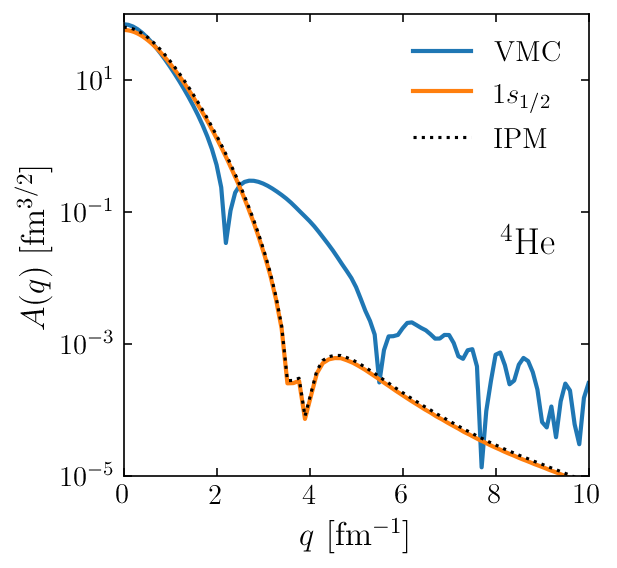

In [13]:
# Plot with log scale on y-axis
plot_spectroscopic_amplitude(
    q_array, q_weights, he4_amplitude_array, alpha,
    ipm_array=he4_ipm_amplitude_array, print_sf=True, show_vmc=True, save=True
)

IPM spectroscopic factor = 2.0023142111966425.
Spectroscopic factor with \delta U^\dagger = 1.6603118272198545.
VMC spectroscopic factor = 1.6221510359897304.


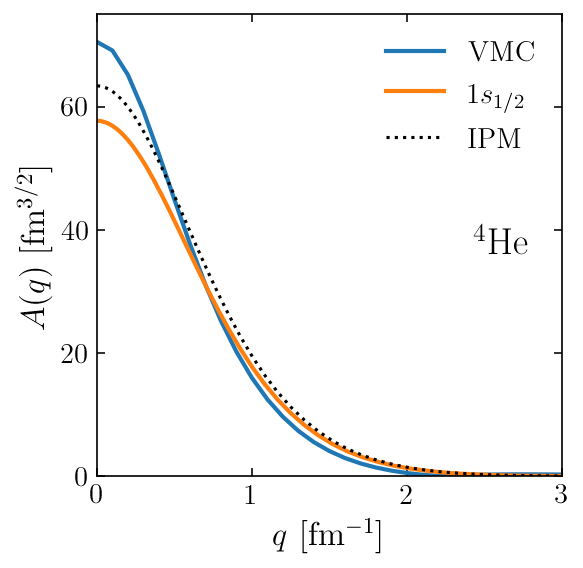

In [14]:
# Plot with linear scale on y-axis
plot_spectroscopic_amplitude(
    q_array, q_weights, he4_amplitude_array, alpha,
    ipm_array=he4_ipm_amplitude_array, x_limits=(0,3), y_limits=(0,75),
    y_scale='linear', print_sf=True, show_vmc=True, save=True
)

### Tests for $^{16}$O

In [15]:
nucleus_name, Z, N = 'O16', 8, 8
n_max, l_max = 2, 2  # Decided on this from examining s.p. wf figure
channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1', '3P0', '3P1',
            '1P1')
kvnn = 6

sa = SpectroscopicAmplitude(nucleus_name, Z, N, n_max, l_max, channels, kvnn)

 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           2           2
 j=           5           5
 wood saxon ordering
 n=           1           1
 l=           0           2
 j=           1           3
 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           2           2
 j=           5           5
 wood saxon ordering
 n=           1           1
 l=   

In [16]:
# 1s_{1/2} proton
alpha = SingleParticleState(1, 0, 1/2, 1/2, 1/2)

# Compute using only the I term
o16_s12_ipm_amplitude_array = sa.compute_amplitude(alpha, print_sf=True,
                                                   sanity_check=True)

# Full spectroscopic amplitude
q_array, q_weights, o16_s12_amplitude_array = sa.get_amplitude(alpha,
                                                               print_sf=True)

Spectroscopic factor = 2.002233177193934.
Spectroscopic factor = 1.4390854478434862.


IPM spectroscopic factor = 2.0022331771939346.
Spectroscopic factor with \delta U^\dagger = 1.4390854478434865.


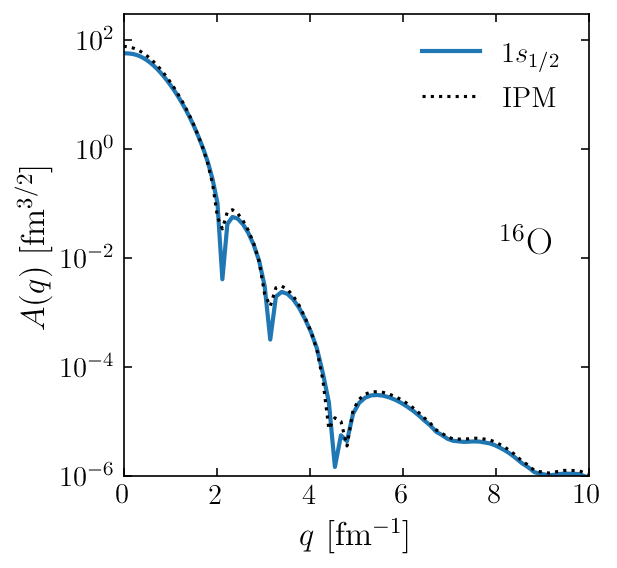

In [17]:
# Plot with log scale for y-axis
plot_spectroscopic_amplitude(
    q_array, q_weights, o16_s12_amplitude_array, alpha,
    ipm_array=o16_s12_ipm_amplitude_array, y_limits=(1e-6, 3e2), print_sf=True,
    show_vmc=False, save=True
)

IPM spectroscopic factor = 2.0022331771939346.
Spectroscopic factor with \delta U^\dagger = 1.4390854478434865.


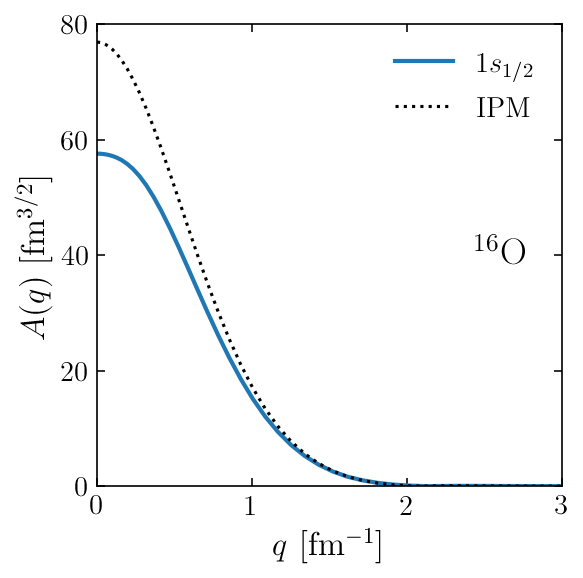

In [18]:
# Plot with linear scale for y-axis
plot_spectroscopic_amplitude(
    q_array, q_weights, o16_s12_amplitude_array, alpha,
    ipm_array=o16_s12_ipm_amplitude_array, x_limits=(0,3), y_limits=(0,80),
    y_scale='linear', print_sf=True, show_vmc=False, save=True
)

In [19]:
# 1p_{3/2} proton
alpha = SingleParticleState(1, 1, 3/2, 3/2, 1/2)

# Compute using only the I term
o16_p32_ipm_amplitude_array = sa.compute_amplitude(alpha, print_sf=True,
                                                   sanity_check=True)

# Full spectroscopic amplitude
q_array, q_weights, o16_p32_amplitude_array = sa.get_amplitude(alpha,
                                                               print_sf=True)

Spectroscopic factor = 4.001699289434939.
Spectroscopic factor = 3.21705397871701.


IPM spectroscopic factor = 4.001699289434939.
Spectroscopic factor with \delta U^\dagger = 3.2170539787170105.


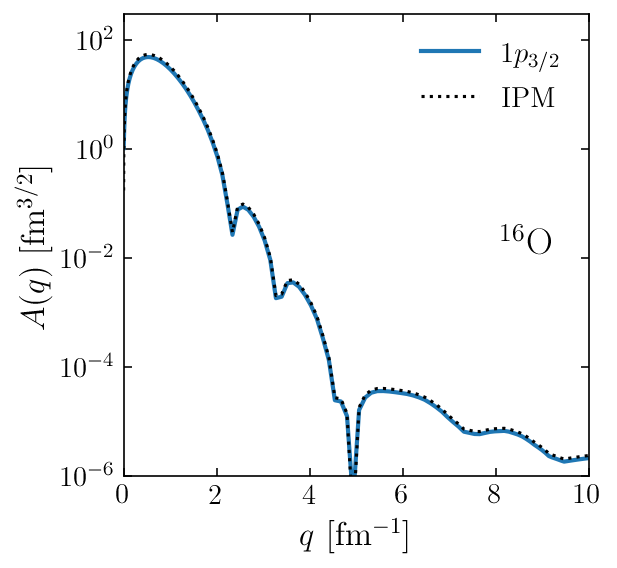

In [20]:
# Plot with log scale for y-axis
plot_spectroscopic_amplitude(
    q_array, q_weights, o16_p32_amplitude_array, alpha,
    ipm_array=o16_p32_ipm_amplitude_array, y_limits=(1e-6, 3e2), print_sf=True,
    show_vmc=False, save=True
)

IPM spectroscopic factor = 4.001699289434939.
Spectroscopic factor with \delta U^\dagger = 3.2170539787170105.


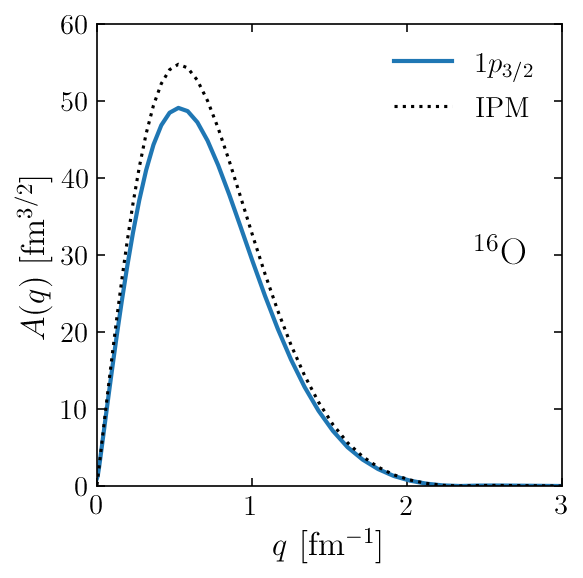

In [21]:
# Plot with linear scale for y-axis
plot_spectroscopic_amplitude(
    q_array, q_weights, o16_p32_amplitude_array, alpha,
    ipm_array=o16_p32_ipm_amplitude_array, x_limits=(0,3), y_limits=(0,60),
    y_scale='linear', print_sf=True, show_vmc=False, save=True
)

In [22]:
# 1p_{1/2} proton
alpha = SingleParticleState(1, 1, 1/2, 1/2, 1/2)

# Compute using only the I term
o16_p12_ipm_amplitude_array = sa.compute_amplitude(alpha, print_sf=True,
                                                   sanity_check=True)

# Full spectroscopic amplitude
q_array, q_weights, o16_p12_amplitude_array = sa.get_amplitude(alpha,
                                                               print_sf=True)

Spectroscopic factor = 2.0009710440090553.
Spectroscopic factor = 1.6212424083711934.


IPM spectroscopic factor = 2.000971044009056.
Spectroscopic factor with \delta U^\dagger = 1.6212424083711938.


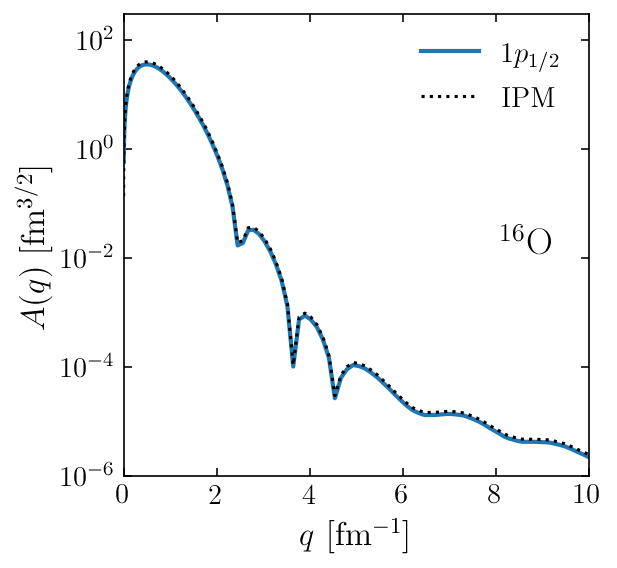

In [23]:
plot_spectroscopic_amplitude(
    q_array, q_weights, o16_p12_amplitude_array, alpha,
    ipm_array=o16_p12_ipm_amplitude_array, y_limits=(1e-6, 3e2), print_sf=True,
    show_vmc=False, save=True
)

IPM spectroscopic factor = 2.000971044009056.
Spectroscopic factor with \delta U^\dagger = 1.6212424083711938.


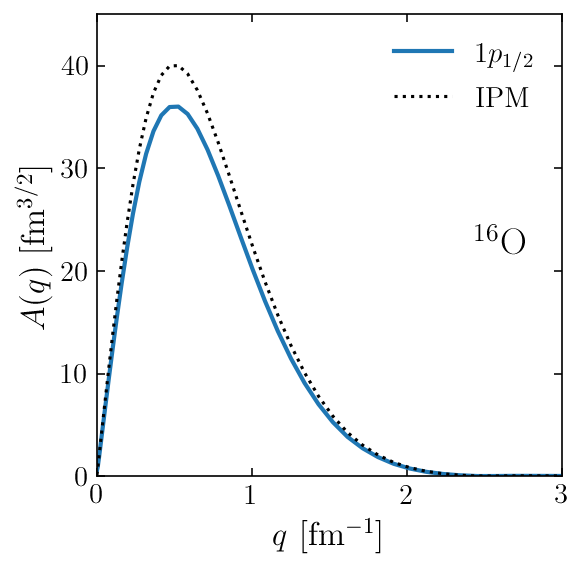

In [24]:
plot_spectroscopic_amplitude(
    q_array, q_weights, o16_p12_amplitude_array, alpha,
    ipm_array=o16_p12_ipm_amplitude_array, x_limits=(0,3), y_limits=(0,45),
    y_scale='linear', print_sf=True, show_vmc=False, save=True
)

### Test dependence on $m_j$

_Getting the same spectroscopic factor of $3.21$ as before with $m_j=3/2$_.

In [25]:
# 1p_{3/2} proton but with m_j=1/2
alpha = SingleParticleState(1, 1, 3/2, 1/2, 1/2)

# Compute using only the I term
o16_p32_mj12_ipm_amplitude_array = sa.compute_amplitude(alpha, print_sf=True,
                                                        sanity_check=True)

# Full spectroscopic amplitude
q_array, q_weights, o16_p32_mj12_amplitude_array = sa.get_amplitude(
    alpha, print_sf=True)

Spectroscopic factor = 4.001689869397053.
Spectroscopic factor = 3.2119004185161257.


IPM spectroscopic factor = 4.001689869397053.
Spectroscopic factor with \delta U^\dagger = 3.211900418516126.


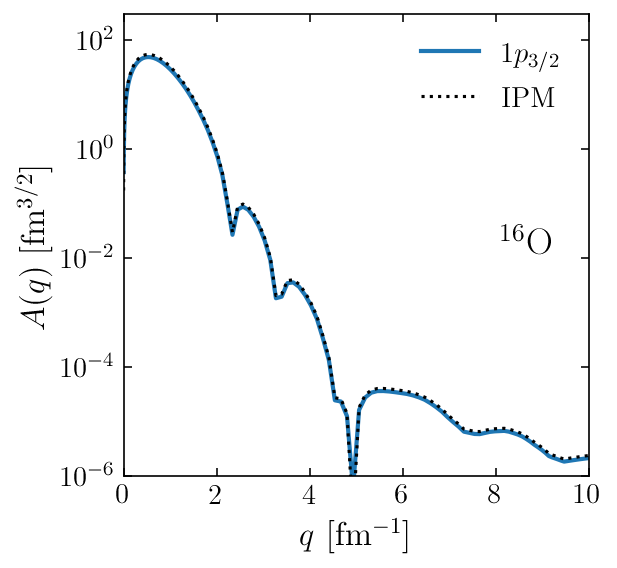

In [26]:
plot_spectroscopic_amplitude(
    q_array, q_weights, o16_p32_mj12_amplitude_array, alpha,
    ipm_array=o16_p32_mj12_ipm_amplitude_array, y_limits=(1e-6, 3e2),
    print_sf=True, show_vmc=False, save=False
)

IPM spectroscopic factor = 4.001689869397053.
Spectroscopic factor with \delta U^\dagger = 3.211900418516126.


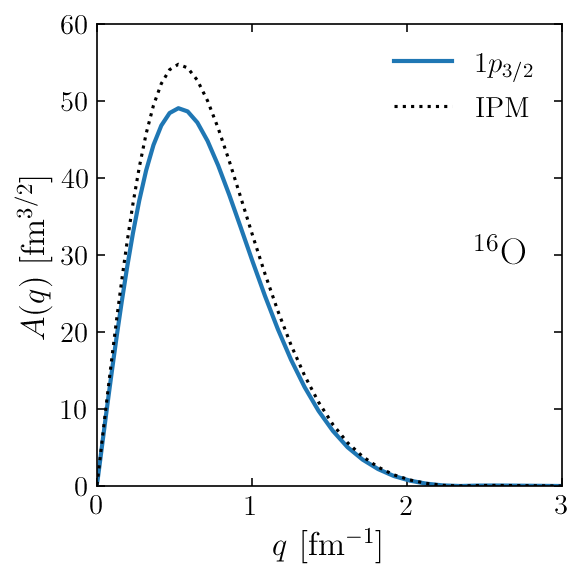

In [27]:
plot_spectroscopic_amplitude(
    q_array, q_weights, o16_p32_mj12_amplitude_array, alpha,
    ipm_array=o16_p32_mj12_ipm_amplitude_array, x_limits=(0,3), y_limits=(0,60),
    y_scale='linear', print_sf=True, show_vmc=False, save=False
)

### Check $^{16}$O proton momentum distribution

$n(\mathbf{q})
= \langle \Psi_0^A | a^{\dagger}_{\mathbf{q}} a_{\mathbf{q}} | \Psi_0^A \rangle
= \sum_\alpha |\langle \Psi_\alpha^{A-1} | a_{\mathbf{q}} | \Psi_0^A \rangle|^2$

 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           2           2
 j=           5           5
 wood saxon ordering
 n=           1           1
 l=           0           2
 j=           1           3
 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           2           2
 j=           5           5
 wood saxon ordering
 n=           1           1
 l=   

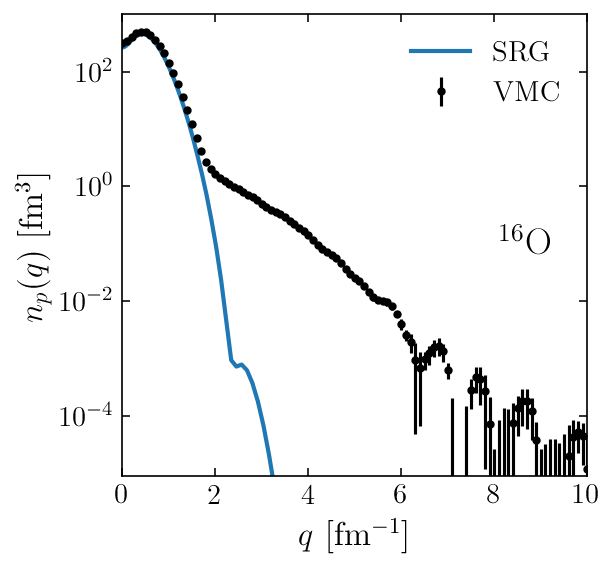

In [36]:
proton_momentum_distribution(
    nucleus_name, Z, N, n_max, l_max, channels, kvnn, print_normalization=True,
    show_vmc=True, save=True
)

In [12]:
# testing
nucleus_name, Z, N = 'He4', 2, 2
n_max, l_max = 2, 1
channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1', '3P0', '3P1',
            '1P1')
kvnn = 6

deludag = DeltaUDagger(nucleus_name, Z, N, n_max, l_max, channels, kvnn)

 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1


In [15]:
s_proton = SingleParticleState(1, 0, 1/2, 1/2, 1/2)
s_neutron = SingleParticleState(1, 0, 1/2, 1/2, -1/2)
p_proton = SingleParticleState(1, 1, 1/2, 1/2, 1/2)
p_neutron = SingleParticleState(1, 1, 1/2, 1/2, -1/2)

In [13]:
# s - s - s - s \delta U^\dagger
print(deludag.compute_matrix_element(s_proton, s_neutron, s_proton, s_neutron))

(-0.050770959076968256+3.7266911516314975e-05j)


In [16]:
# p - p - s - s \delta U^\dagger
print(deludag.compute_matrix_element(p_proton, p_neutron, s_proton, s_neutron))

(0.003234462873200764-3.3982868993839377e-06j)
